# Logistic Regression

This file contains the code for building Logistic Regression Models with L1 regularization for the binary and tasks. The models are trained on the concatenated dataset as well as single proteomics data. The hyperparameters are tuned using Grid Search Cross Validation.

In [1]:
import shap
from methods.helper import *
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import lime.lime_tabular
from sklearn.linear_model import LogisticRegression
# Supress all warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\mjgoj\miniconda3\Lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Loading the three omics datasets and splitting it into predefined train / test split (60 -40)

In [2]:
# Load data
lipidomics, metabolomics, proteomics = load_data()
# Get the train - test split
lipidomics_train, lipidomics_test = get_train_test_split_dataset(lipidomics)
metabolomics_train, metabolomics_test = get_train_test_split_dataset(metabolomics)
proteomics_train, proteomics_test = get_train_test_split_dataset(proteomics)

# Load the binary dataset
X_train, X_test, Y_train, y_test = concatenate_data(
    lipidomics, metabolomics, proteomics, num_classes=2)

**Standardizing the data**
This is crucial for regularized models as features with larger scales dominate the regularization

In [3]:
def standardize(X):
    """
    Standardize the data using the StandardScaler
    This is crucial for regularized models
    (otherwise features with larger scales dominate the regularization)
    :param X: Data
    """
    scaler = StandardScaler()
    # Get the columns of the data
    columns = X.columns
    scaled_data = scaler.fit_transform(X)
    return pd.DataFrame(scaled_data, columns=columns)

In [4]:
# Standardize the data
X_train = standardize(X_train)
X_test = standardize(X_test)

# Logistic Regression

### 1. No Regularization
First, the logistic regression model is trained without any regularization. This is done to get a baseline performance of the model.

In [29]:
# Fit the model
model = LogisticRegression(
    max_iter=1000,
    multi_class='ovr', # Binary classification
    class_weight='balanced',
    penalty='none', # No regularization
).fit(X_train, Y_train)

Accuracy of the model: 0.5789
Recall of the model: 0.5789
Precision of the model: 0.5850
Weighted F1 score of the model: 0.5539
Matthews Correlation Coefficient of the model: 0.1512


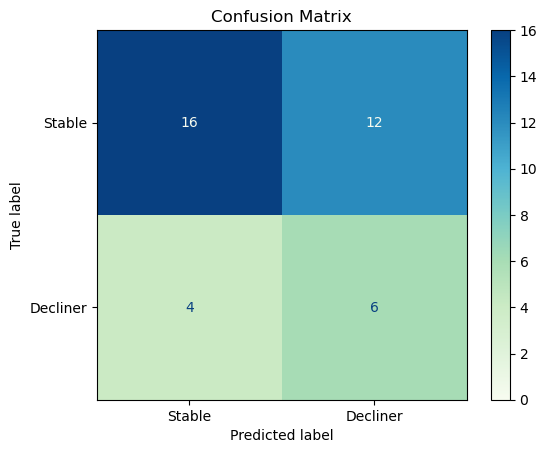

In [30]:
# Evaluate the model
y_pred = model.predict(X_test)
evaluate_model(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)

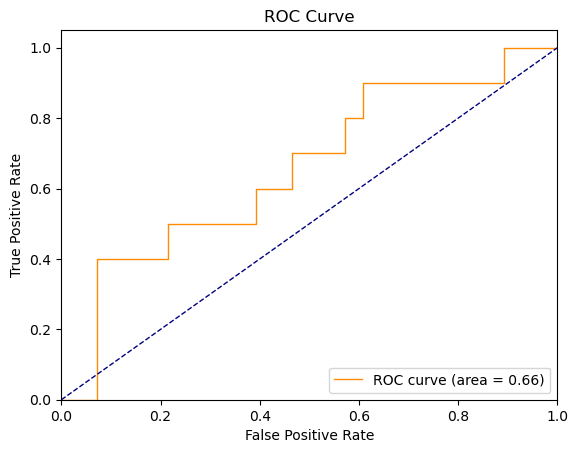

In [31]:
# Get the continuous predictions
y_pred_continuous = model.predict_proba(X_test)[:, 1]
plot_ROC_curve(y_pred_continuous, y_test)

### 2. Hyperparameter Tuning - Regularization
Next, the model is trained with L1 regularization and hyperparameter tuning is done to find the best combination of hyperparameters.

In [32]:
hyperparams = {
    # Inverse of regularization strength
    'C': [2.0, 1.0, 0.8, 0.7, 0.6, 0.5, 0.4]
}
    
# Fit the model using grid search to find the best combination of hyperparameters
grid_search = GridSearchCV(
    estimator=LogisticRegression(
        max_iter=1000,
        multi_class='ovr', # Binary classification
        class_weight='balanced',
        penalty='l1', # Lasso Regularization
        solver='saga',
        random_state=42
    ),
    param_grid=hyperparams,
    scoring='f1',
    cv=10,
    n_jobs=-1
).fit(X_train, Y_train)
# Print the best hyperparameters
print(grid_search.best_params_)
best_model = grid_search.best_estimator_

{'C': 2.0}


Accuracy of the model: 0.7368
Recall of the model: 0.7368
Precision of the model: 0.7504
Weighted F1 score of the model: 0.7223
Matthews Correlation Coefficient of the model: 0.4587


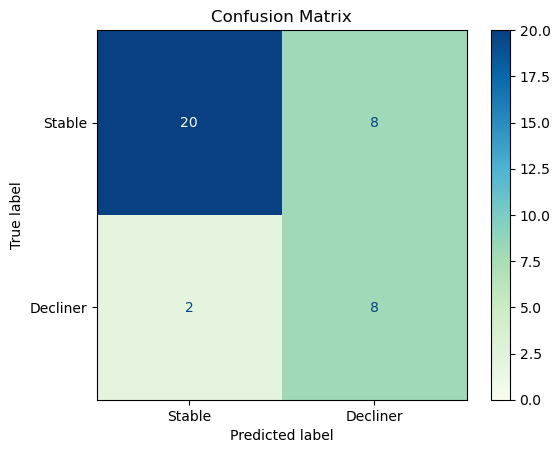


Penalty term: 0.5


In [33]:
# Evaluate the model
y_pred = best_model.predict(X_test)
evaluate_model(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)

print('\nPenalty term:', round(1 / best_model.C, 2))

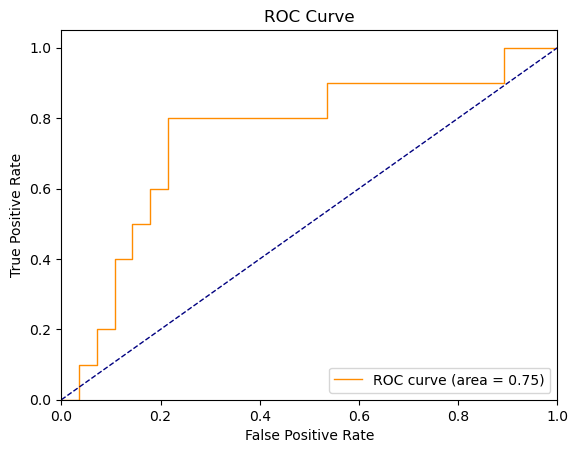

In [34]:
y_pred_continuous = best_model.predict_proba(X_test)[:, 1]
plot_ROC_curve(y_pred_continuous, y_test)

# Proteomics Model
Now, the model is trained using only the proteomics data to see how well it performs compared to the concatenated dataset.

In [35]:
# Drop columns including the target variables
proteomics_train = proteomics_train.drop(columns=["TwoClass", "RID", "ThreeClass"])
proteomics_test = proteomics_test.drop(columns=["TwoClass", "RID", "ThreeClass"])

In [36]:
# Fit the model using grid search to find the best combination of hyperparameters
grid_search_proteomics = GridSearchCV(
    estimator=LogisticRegression(
        max_iter=1000,
        multi_class='ovr', # Binary classification
        class_weight='balanced',
        penalty='l1', # Lasso Regularization
        solver='saga',
        random_state=42
    ),
    param_grid=hyperparams,
    scoring='f1',
    cv=10,
    n_jobs=-1
).fit(proteomics_train, Y_train)

{'C': 2.0}
Accuracy of the model: 0.5789
Recall of the model: 0.5789
Precision of the model: 0.5850
Weighted F1 score of the model: 0.5539
Matthews Correlation Coefficient of the model: 0.1512


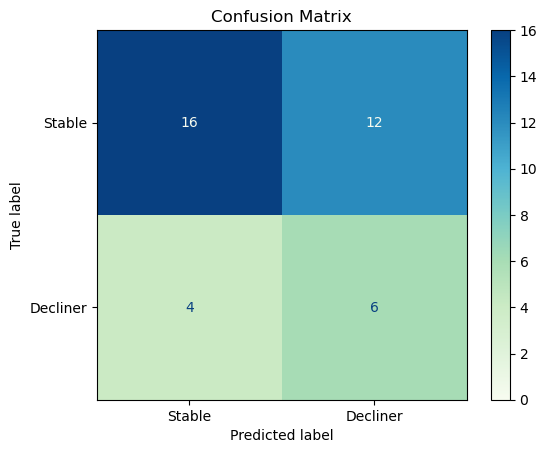

In [37]:
# Print the best hyperparameters
print(grid_search_proteomics.best_params_)
best_model_proteomics = grid_search_proteomics.best_estimator_

y_pred = best_model_proteomics.predict(proteomics_test)
evaluate_model(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)   

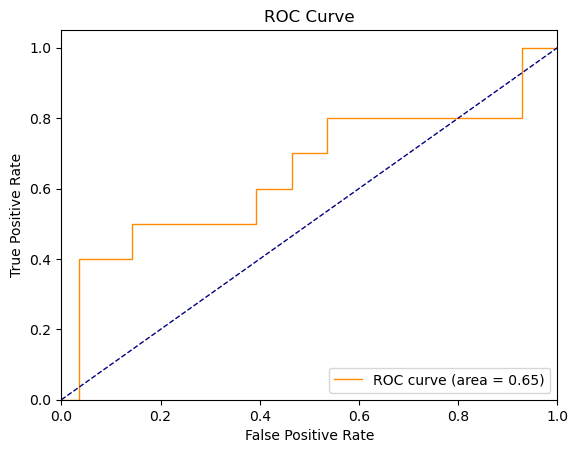

In [38]:
y_pred_continuous = best_model_proteomics.predict_proba(proteomics_test)[:, 1]
plot_ROC_curve(y_pred_continuous, y_test)

## Investigation of the Selected Features
Lasso regularization is used to select the most important features. The features with 0 coefficients are removed from the dataset. The distribution of the selected features among the omics data is visualized.

In [39]:
# Get the features with 0 coefficients
coefficients = best_model.coef_[0]
zero_features = np.where(coefficients == 0)[0]

print(f'Number of features with 0 coefficients: {len(zero_features)} out of {len(coefficients)}')

# Get the names of the features
feature_names = X_train.columns
non_zero_features = np.where(coefficients != 0)[0]
non_zero_features_names = np.array(feature_names)[non_zero_features]
print("Number of selected features:", len(non_zero_features))

Number of features with 0 coefficients: 964 out of 1112
Number of selected features: 148


In [40]:
features_data = []
for feature, coef in zip(non_zero_features_names, coefficients[non_zero_features]):
    data_type = get_omics_type(feature)
    features_data.append({'Feature': feature, 'Coefficient': coef, 'Type': data_type})
features_df = pd.DataFrame(features_data)
print(features_df.head(5))

               Feature  Coefficient        Type
0  ACYLCARNITINE_16_0_    -0.040650  Lipidomics
1  ACYLCARNITINE_18_1_    -0.188892  Lipidomics
2             CE_15_0_     0.039766  Lipidomics
3             CE_16_1_     0.064952  Lipidomics
4             CE_24_6_     0.283935  Lipidomics


In [41]:
# Create a dataframe with columns for each data type
plot_df = pd.DataFrame(columns=['Lipidomics', 'Metabolomics', 'Proteomics'])
# Add initial distribution of the features
plot_df.loc['Initial'] = [
    len(lipidomics.columns) - 3, 
    len(metabolomics.columns) - 3, 
    len(proteomics.columns) - 3]
# Add the distribution of the selected features
plot_df.loc['Selected'] = features_df['Type'].value_counts()
# Fill NaN values with 0
plot_df = plot_df.fillna(0)
# Round to integers
plot_df = plot_df.astype(int)
print(plot_df)

          Lipidomics  Metabolomics  Proteomics
Initial          579           213         320
Selected          77            15          56


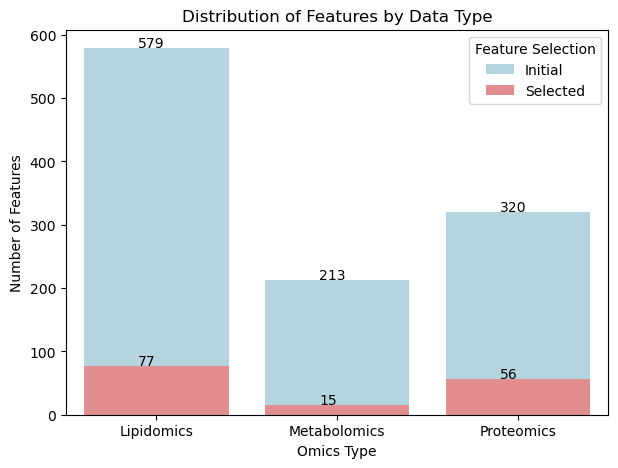

In [42]:
# Plot distribution among the omics data
fig, ax = plt.subplots(figsize=(7, 5))

# Plot initial distribution
sns.barplot(data=plot_df.T, x=plot_df.columns, y='Initial', color='lightblue', label='Initial')
# Plot selected features
sns.barplot(data=plot_df.T, x=plot_df.columns, y='Selected', color='lightcoral', label='Selected')

# Add the count of each class on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x()+0.3, p.get_height()+1))

ax.set_ylabel('Number of Features')
ax.set_xlabel('Omics Type')
ax.set_title('Distribution of Features by Data Type')
plt.legend(title='Feature Selection')
plt.show()


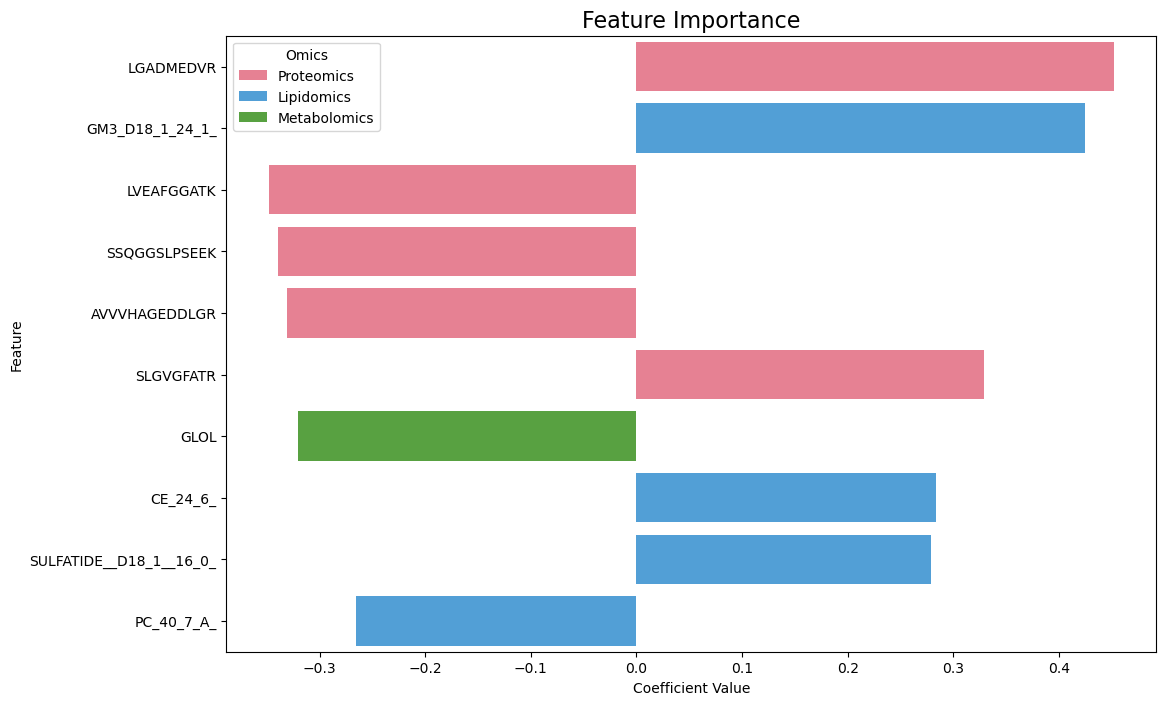

In [43]:
non_zero_coefficients = coefficients[non_zero_features]
plot_feature_importance(
    non_zero_coefficients, non_zero_features_names)